# **Skenario 1 - CNN VGG16**

Skenario 1 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Import modul-modul yang diperlukan untuk pengolahan citra medis, termasuk pembacaan citra dengan `SimpleITK`, manipulasi array dengan `NumPy`, visualisasi dengan `Matplotlib`, dan perhitungan entropy dengan `scipy.stats`

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

cari dan cetak data `selected_image.npz` di dalam struktur direktori

In [2]:
directory_path = r"D:\Documents\Kuliah\.SKRIPSI\KLASIFIKASI ALZHEIMER\Coding\Notebook\Preprocessing\selected_image.npz"
loaded_data = np.load(directory_path, allow_pickle=True)

combined_slices = loaded_data['combined_slices'].item()

for label, plane_slices in combined_slices.items():
    for plane, result_slices in plane_slices.items():
        total_slices = len(result_slices)
        
        print(f"Label: {label}, Plane: {plane}, Jumlah Total Slice: {total_slices}")

        # Menampilkan bentuk (shape) dari setiap slice
        for i, (position, resized_slice) in enumerate(result_slices):
            print(f"  Resized Slice {i+1} - Position: {position}, Shape: {resized_slice.shape}")

Label: AD, Plane: coronal, Jumlah Total Slice: 60
  Resized Slice 1 - Position: 107, Shape: (224, 224)
  Resized Slice 2 - Position: 111, Shape: (224, 224)
  Resized Slice 3 - Position: 110, Shape: (224, 224)
  Resized Slice 4 - Position: 122, Shape: (224, 224)
  Resized Slice 5 - Position: 121, Shape: (224, 224)
  Resized Slice 6 - Position: 123, Shape: (224, 224)
  Resized Slice 7 - Position: 132, Shape: (224, 224)
  Resized Slice 8 - Position: 131, Shape: (224, 224)
  Resized Slice 9 - Position: 133, Shape: (224, 224)
  Resized Slice 10 - Position: 136, Shape: (224, 224)
  Resized Slice 11 - Position: 135, Shape: (224, 224)
  Resized Slice 12 - Position: 137, Shape: (224, 224)
  Resized Slice 13 - Position: 136, Shape: (224, 224)
  Resized Slice 14 - Position: 137, Shape: (224, 224)
  Resized Slice 15 - Position: 135, Shape: (224, 224)
  Resized Slice 16 - Position: 133, Shape: (224, 224)
  Resized Slice 17 - Position: 132, Shape: (224, 224)
  Resized Slice 18 - Position: 131, Shape

### 2.2 Pembagian Data
code dibawah ini digunakan untuk menyiapkan data sebelum diolah, dilakukan konversi potongan gambar hasil preprocessing dari `combined_slices` ke dalam format yang dapat digunakan untuk pelatihan model, sehingga menciptakan array `X` yang berisi potongan gambar dan array `y` yang berisi label kelas yang sesuai, dengan label kelas diubah menjadi representasi numerik menggunakan `LabelEncoder`.

In [3]:
X = []
y = []

for label, plane_slices in combined_slices.items():
    for plane, result_slices in plane_slices.items():
        X.extend([np.expand_dims(slice_data, axis=-1) for _, slice_data in result_slices])
        y.extend([label] * len(result_slices))

X = np.array(X)
y = np.array(y)

In [4]:
# Menggunakan LabelEncoder untuk mengonversi label menjadi nilai numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print(f"Jumlah Total Data Train: {len(X_train)}")
print(f"Jumlah Total Data Test: {len(X_test)}")

Jumlah Total Data Train: 576
Jumlah Total Data Test: 144


## 3. Data Preprocessing

### 3.1 Normalisasi dan Penyesuaian Format Citra
penetapan parameter `batch_size`, lalu menggunakan `K-Fold` untuk menentukan konfigurasi dengan k-fold cross-validationnya 5 fold

In [6]:
mean = 0.485
std = 0.229

X_train_normalized = (X_train / 255.0 - mean) / std
X_test_normalized = (X_test / 255.0 - mean) / std

# Ubah gambar grayscale menjadi gambar RGB
X_train_rgb = np.repeat(X_train_normalized, 3, axis=-1)
X_test_rgb = np.repeat(X_test_normalized, 3, axis=-1)

# Cek dimensi gambar sebelum normalisasi
print(X_train_rgb.shape)
print(X_test_rgb.shape)

(576, 224, 224, 3)
(144, 224, 224, 3)


### 3.2 Membuat Dataset dari Tensor
menggunakan TensorFlow untuk membuat dataset dari tensor (X_train_rgb, y_train) dan (X_test_rgb, y_test), kemudian mengonfigurasi dataset tersebut menjadi batch dengan ukuran 32 untuk meningkatkan efisiensi pelatihan dan penggunaan memori.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_rgb, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_rgb, y_test))

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## 4. Modeling

vgg16_model = VGG16(weights='imagenet')
vgg16_model.summary()

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.1 Training
implementasikan transfer learning menggunakan arsitektur model VGG16 yang telah dilatih sebelumnya pada dataset ImageNet, setelah itu latih menggunakan data yang telah dipersiapkan sebelumnya

In [9]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
18/18 [==============================] - 379s 21s/step - loss: 4.4227 - accuracy: 0.3108 - val_loss: 1.2578 - val_accuracy: 0.5000
Epoch 2/10
18/18 [==============================] - 347s 19s/step - loss: 1.0868 - accuracy: 0.5330 - val_loss: 0.9658 - val_accuracy: 0.6667
Epoch 3/10
18/18 [==============================] - 419s 24s/step - loss: 0.9189 - accuracy: 0.6146 - val_loss: 0.7865 - val_accuracy: 0.6875
Epoch 4/10
18/18 [==============================] - 363s 20s/step - loss: 0.7470 - accuracy: 0.7014 - val_loss: 0.6776 - val_accuracy: 0.7569
Epoch 5/10
18/18 [==============================] - 401s 22s/step - loss: 0.6035 - accuracy: 0.7604 - val_loss: 0.5522 - val_accuracy: 0.8542
Epoch 6/10
18/18 [==============================] - 349s 19s/step - loss: 0.4897 - accuracy: 0.8247 - val_loss: 0.5153 - val_accuracy: 0.8611
Epoch 7/10
18/18 [==============================] - 288s 16s/step - loss: 0.4993 - accuracy: 0.8194 - val_loss: 0.4835 - val_accuracy: 0.8889
Epoch 

### 4.2 Model Evaluation

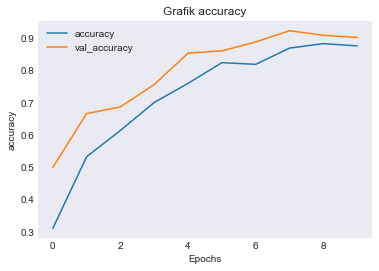

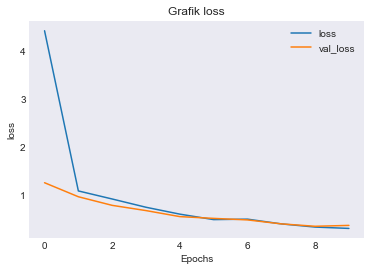

In [10]:
def grafik_plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Grafik ' + string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

grafik_plot(history, "accuracy")
grafik_plot(history, "loss")

### 4.3 Testing

Prediksi label citra dengan data test

In [11]:
true_labels = []
predictions = []

for x, y_true in test_dataset:
    true_labels.extend(tf.argmax(y_true, axis=1).numpy())
    y_pred = model.predict(x)
    predictions.extend(tf.argmax(y_pred, axis=1).numpy())

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

# Evaluasi model
test_model = model.evaluate(test_dataset, verbose=1)

Label Sebenarnya :  [1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 3, 2, 0, 0, 2, 1, 0, 3, 1, 1, 2, 2, 0, 3, 2, 1, 1, 1, 0, 0, 2, 2, 1, 2, 3, 3, 3, 3, 3, 2, 1, 0, 0, 3, 2, 0, 1, 3, 3, 0, 2, 3, 2, 3, 0, 1, 1, 1, 0, 1, 2, 0, 0, 2, 1, 0, 3, 0, 2, 3, 3, 2, 0, 2, 0, 2, 3, 1, 3, 1, 2, 1, 1, 1, 0, 2, 3, 1, 2, 3, 1, 0, 1, 1, 0, 1, 0, 0, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 3, 0, 2, 1, 2, 0, 3, 0, 0, 2, 3, 0, 1, 0, 2, 3, 3, 2, 3, 2, 1, 3, 1, 3, 0, 0, 1, 0, 0, 1, 0, 2]
Label Prediksi :  [1, 1, 3, 1, 2, 2, 0, 0, 1, 2, 3, 2, 0, 0, 2, 3, 0, 3, 1, 1, 2, 2, 0, 3, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 3, 3, 3, 3, 3, 2, 1, 2, 0, 3, 2, 0, 1, 3, 3, 0, 2, 1, 2, 3, 0, 1, 1, 3, 0, 3, 2, 0, 0, 2, 1, 0, 3, 0, 2, 3, 3, 2, 0, 2, 0, 2, 3, 1, 3, 3, 2, 1, 1, 1, 0, 2, 3, 1, 2, 3, 1, 3, 1, 1, 0, 1, 0, 0, 3, 0, 1, 3, 3, 1, 2, 1, 1, 1, 1, 3, 0, 2, 3, 0, 2, 3, 2, 0, 3, 0, 0, 2, 3, 0, 1, 0, 2, 3, 3, 2, 3, 2, 1, 3, 2, 3, 0, 0, 1, 0, 0, 1, 0, 2]
5/5 [==============================] - 56s 11s/step - loss: 0.3690 - accuracy: 0.9028


Coba prediksi dengan beberapa citra

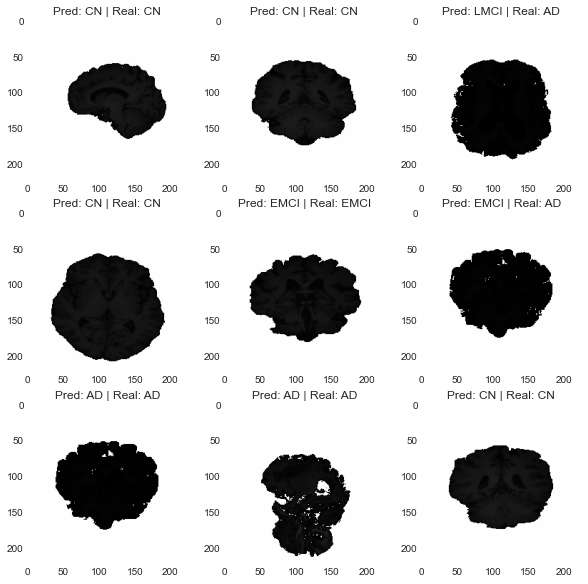

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    predictions = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = np.argmax(predictions[i])
        true_label = np.argmax(labels[i])
        plt.title("Pred: " + class_names[predicted_label] + " | Real: " + class_names[true_label])

plt.show()

## 5. Evaluation

Mendefinisikan Specificity dan Sensitivity Functions

In [14]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi pada train set

In [15]:
loss, accuracy, specificity, sensitivity = model.evaluate(train_dataset)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

18/18 [==============================] - 400s 20s/step - loss: 0.1243 - accuracy: 0.9878 - specificity: 0.9994 - sensitivity: 0.9635
Loss train set:  0.12431788444519043
Akurasi train set:  0.9878472089767456
Specificity train set:  0.9994213581085205
Sensitivity train set:  0.9635416865348816


Evaluasi pada test set

In [16]:
loss, accuracy, specificity, sensitivity = model.evaluate(test_dataset)
print('Loss test set: ', loss)
print('Akurasi test set: ', accuracy)
print('Specificity test set: ', specificity)
print('Sensitivity test set: ', sensitivity)

5/5 [==============================] - 151s 27s/step - loss: 0.3690 - accuracy: 0.9028 - specificity: 0.9854 - sensitivity: 0.8250
Loss test set:  0.369043231010437
Akurasi test set:  0.9027777910232544
Specificity test set:  0.98541659116745
Sensitivity test set:  0.824999988079071


Hasil evaluasi menggunakan confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix

# Loop through the test dataset and make predictions
for x, y_true in test_dataset:
    true_labels.extend(tf.argmax(y_true, axis=1).numpy())
    y_pred = model.predict(x)
    predictions.extend(tf.argmax(y_pred, axis=1).numpy())

# Menghitung confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Menampilkan confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'extend'

In [ ]:
from sklearn.metrics import classification_report

# Mencetak classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

Hasil evaluasi menggunakan Grafik AUC

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Memprediksi probabilitas kelas positif pada data uji
probabilities = model.predict(test_dataset)

# Menghitung AUC
auc_score = roc_auc_score(true_labels, probabilities, multi_class='ovr')

# Menggambar kurva ROC
fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 4])  # Ganti 1 dengan indeks kelas yang diinginkan
roc_auc = auc(fpr, tpr)

# Menampilkan grafik ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [304, 144]